In [1]:
#default_exp data_exploration

In [2]:
# export
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import toolz

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
%matplotlib inline

In [5]:
tf.strings.split('hello world').numpy()

array([b'hello', b'world'], dtype=object)

In [6]:
# export
def map_class_to_taxon(mapping, class_id, taxon='Family'):
    return mapping.loc[class_id][taxon]


def parse_image(filename, image_size=224):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [image_size, image_size])
    return image

In [7]:
# export
DATA_DIR = os.path.join('..', 'data')

metadata_path = os.path.join(DATA_DIR, 'PlantCLEF2019MasterTraining.csv') 
metadata_df = pd.read_csv(metadata_path, sep=';')
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434251 entries, 0 to 434250
Data columns (total 10 columns):
MediaId        434251 non-null object
YearInCLEF     434251 non-null object
LearnTag       434251 non-null object
ClassId        434251 non-null int64
Species        434251 non-null object
Genus          434251 non-null object
Family         434251 non-null object
Origin         434251 non-null object
OriginalUrl    434251 non-null object
BackupLink     434251 non-null object
dtypes: int64(1), object(9)
memory usage: 33.1+ MB


In [8]:
metadata_df.head()

,MediaId,YearInCLEF,LearnTag,ClassId,Species,Genus,Family,Origin,OriginalUrl,BackupLink
0,5c3e30f1706244e9f199d5a0c5a5ec00d1cbf473,PlantCLEF2019,Train,183350,Taralea oppositifolia Aubl.,Taralea,Leguminosae,microsoftimage,http://www.bing.com/cr?IG=E56D8ED3E44B4D6BB7E1...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/183350/5...
1,83cead55f3be63d6fbe0c1e6c87ee2223c7a6e9b,PlantCLEF2019,Train,12254,Anacardium occidentale L.,Anacardium,Anacardiaceae,microsoftimage,http://www.bing.com/cr?IG=8DC6223C2EBC42F0A017...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/12254/83...
2,1e2f13d4773a8feafb68930117d1773ba712aa79,PlantCLEF2019,Train,263952,Ischaemum muticum L.,Ischaemum,Poaceae,microsoftimage,http://www.bing.com/cr?IG=DDA2A184733547F09081...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/263952/1...
3,5e49ad7196984b90ad1c5f8648fe77803b40a75b,PlantCLEF2019,Train,158247,Mezilaurus decurrens (Ducke) Kosterm.,Mezilaurus,Lauraceae,googleimage,https://encrypted-tbn0.gstatic.com/images?q=tb...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/158247/5...
4,109240430bfcca5a7c3eec0fc6a165ad242e7d55,PlantCLEF2019,Train,24496,Tabernaemontana grandiflora Jacq.,Tabernaemontana,Apocynaceae,microsoftimage,https://www.bing.com/cr?IG=836545099C7F450589B...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/24496/10...


In [9]:
family_counts = metadata_df['Family'].value_counts()
family_counts[family_counts > 1000].sum()

388594

In [10]:
# export
class_taxa_mapping = metadata_df.groupby('ClassId')['ClassId', 'Family', 'Genus'].apply(lambda df: df)
class_taxa_mapping.index = class_taxa_mapping['ClassId']
class_taxa_mapping = class_taxa_mapping.drop_duplicates('ClassId')

In [11]:
map_class_to_taxon(class_taxa_mapping, 183350)

'Leguminosae'

In [12]:
metadata_df['Family'].value_counts()

Orchidaceae         37703
Leguminosae         30122
Poaceae             26335
Rubiaceae           16441
Malvaceae           14765
                    ...  
Martyniaceae            7
Canellaceae             7
Anisophylleaceae        7
Metaxyaceae             2
Ranunculaceae           1
Name: Family, Length: 248, dtype: int64

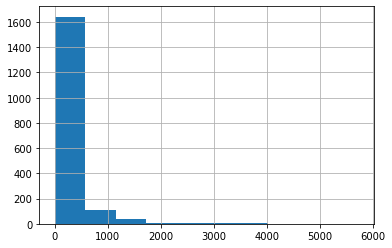

In [13]:
metadata_df['Genus'].value_counts().hist()

In [14]:
metadata_df['ClassId'].unique().shape

(10000,)

In [15]:
metadata_df['Species'].value_counts()[-2000:]

Aristolochia consimilis Mast.                  6
Gunnera silvioana L.E.Mora                     6
Ipomoea bignonioides Sims                      6
Matelea cayennensis Morillo                    6
Aechmea pallida L.B.Sm.                        6
                                              ..
Selaginella flabellata (L.) Spring             1
Notopleura merumensis (Steyerm.) C.M.Taylor    1
Coussarea granvillei Delprete & B.M.Boom       1
Helicostylis pedunculata Benoist               1
Pourouma ferruginea Standl.                    1
Name: Species, Length: 2000, dtype: int64

In [16]:
!ls data/images/data/101969

ls: cannot access 'data/images/data/101969': No such file or directory


In [17]:
# export
train_dir = os.path.join(DATA_DIR, 'images_train/data')

In [18]:
# export

def prepare_classification_metadata(metadata_df, target_col, basepath):
    def make_filename_from_parts(parts):
        return os.path.join(*(basepath, *map(str, parts))) + '.jpg'
    filename = 'MediaId'
    df = pd.DataFrame({'class': metadata_df[target_col], 'name': metadata_df[filename]})
    df['filename'] = metadata_df[['ClassId', filename]].agg(make_filename_from_parts, axis=1)
    return df

In [19]:
sample_metadata_df = metadata_df.iloc[:1000]

In [20]:
sample_classification_df = prepare_classification_metadata(sample_metadata_df, 'Species', train_dir)

In [21]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [22]:
sample_image_iterator = image_gen.flow_from_dataframe(sample_classification_df, target_size=(224, 224))

Found 1000 validated image filenames belonging to 867 classes.


In [23]:
n_classes = len(sample_image_iterator.class_indices)

In [24]:
batch = next(sample_image_iterator)

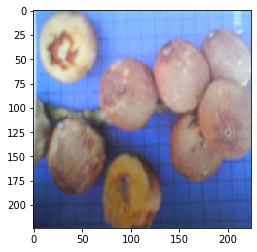

In [25]:
plt.imshow(batch[0][0]);

In [32]:
import keras.applications

base_model = keras.applications.MobileNet(include_top=False, input_shape=(224, 224, 3))
model = keras.Sequential(
    [
        base_model,
        keras.layers.AveragePooling2D((4, 4)),
        keras.layers.Flatten(),
        keras.layers.Dense(n_classes),
        keras.layers.Softmax()
    ])
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam())

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 867)               888675    
_________________________________________________________________
softmax_1 (Softmax)          (None, 867)               0         
Total params: 4,117,539
Trainable params: 4,095,651
Non-trainable params: 21,888
_________________________________________________________________


In [34]:
base_model.input_shape

(None, 224, 224, 3)

In [42]:
model.fit(sample_image_iterator, epochs=10)

Epoch 1/10
32/32 [==============================] - 10s 316ms/step - loss: 6.5499
Epoch 2/10
32/32 [==============================] - 10s 311ms/step - loss: 5.6423
Epoch 3/10
32/32 [==============================] - 10s 305ms/step - loss: 3.9398
Epoch 4/10
32/32 [==============================] - 10s 306ms/step - loss: 1.9899
Epoch 5/10
32/32 [==============================] - 10s 310ms/step - loss: 0.9796
Epoch 6/10
32/32 [==============================] - 10s 319ms/step - loss: 0.5483
Epoch 7/10
32/32 [==============================] - 10s 325ms/step - loss: 0.3430
Epoch 8/10
32/32 [==============================] - 10s 306ms/step - loss: 0.2808
Epoch 9/10
32/32 [==============================] - 10s 308ms/step - loss: 0.1400
Epoch 10/10
32/32 [==============================] - 10s 307ms/step - loss: 0.0838


In [37]:
preds = model.predict(batch[0])

In [41]:
preds[0][preds[0].argmax()]

0.003682344